<a href="https://colab.research.google.com/github/lblum95/AML/blob/master/task1/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#############################  new branch

from google.colab import drive
print("test")
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/AML/task1

test
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/AML/task1


In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import mean_absolute_error

X_test=pd.read_csv('data/X_test.csv')
X_trainR=pd.read_csv('data/X_train.csv',index_col='id')
Y=pd.read_csv('data/y_train.csv',index_col='id')
## Replace NaN by mean of column
X_trainR=X_trainR.where(pd.notna(X_trainR), X_trainR.mean(), axis='columns')
X_train=X_trainR.copy()

## Remove values which are greater than 4x the Std Dev
for col_n in X_train:
  col =X_train[col_n]
  thresh=col.mean()+(3.5*col.std())
  X_train[col_n]=col.where(col<thresh,col.mean())

## Normalize data between [0,1]
X_train=pd.DataFrame(pp.MinMaxScaler().fit_transform(X_train))
## Remove empty columns := where mean is 0
X_train=X_train.loc[:,X_train.mean()>0]
#plt.pcolor(X_train)

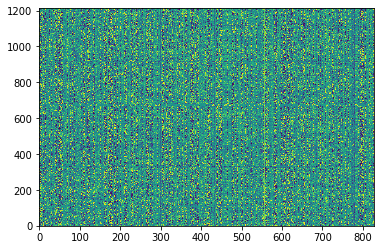

In [127]:
plt.pcolor(X_train)

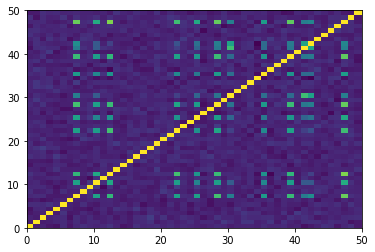

In [134]:
cor = X_train.corr()
plt.pcolor(cor.iloc[:50,:50])

In [68]:
reg = lm.LinearRegression().fit(X_train, Y)
y = reg.predict(X_train)
mean_absolute_error(Y, yh)

12.309895315485747

In [21]:
score=[]
for i in range(50,800,50):
  pca = decomposition.PCA(n_components=i)
  pca.fit(X_train)
  X = pca.transform(X_train)
  reg = lm.LinearRegression().fit(X, Y)
  score.append(reg.score(X, Y))

In [192]:
poly = pp.PolynomialFeatures(degree=2)
X_trainS=poly.fit_transform(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


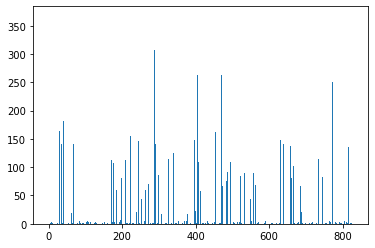

In [24]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train, Y)
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()
n_features=sum(fs.scores_>10)

In [41]:
fs = SelectKBest(score_func=f_regression, k=800)
fs.fit(X_train, Y)
X_train_fs = fs.transform(X_train)
np.shape(X_train_fs)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1212, 800)

In [57]:
reg = lm.LinearRegression().fit(X_train_fs, Y)
#reg.score(X_train_fs, Y)
np.shape(reg.coef_.T)

yh=np.matmul( X_train_fs,reg.coef_.T)
mae = mean_absolute_error(Y, yh)
mae2 = mean_absolute_error(Y, yh-12.3)

print(mae, mae2)

12.498516580409378 3.282612242445715
